In [2]:
!pip install folium haversine scikit-learn matplotlib pandas numpy 


/var/folders/54/b5xwty4d3k76nwf58jmd6g9c0000gp/T/ipykernel_72597/1744076729.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['distance_to_center'] = df.apply(


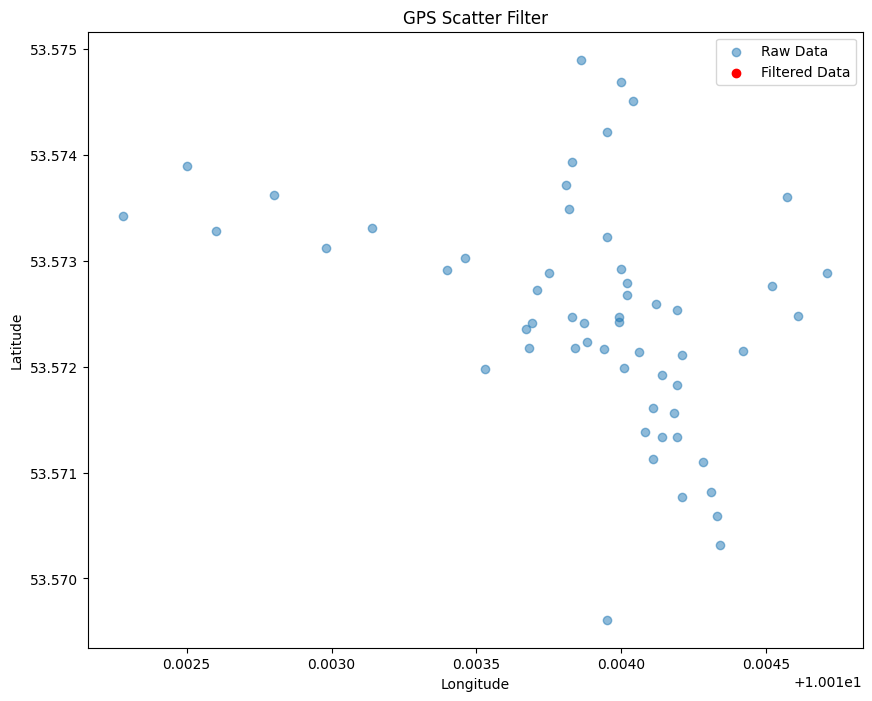

In [3]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from haversine import haversine, Unit
# Load your data (example placeholder)
data = pd.read_json('stop_phase_gps_data.json')

# Convert timestamp from epoch (UTC) to datetime
data['timestamp'] = pd.to_datetime(data['timestamp'], unit='s')

# Function to calculate distance between two points
def haversine_distance(lat1, lon1, lat2, lon2):
    distance = haversine((lat1,lon1),(lat2,lon2), unit=Unit.METERS)

# Calculate center of cluster
def get_cluster_center(df):
    return df['latitude'].mean(), df['longitude'].mean()

# Filter Scattered Points in Stop Phase
def filter_scatter(df, radius_threshold=20):
    center_lat, center_lon = get_cluster_center(df)
    df['distance_to_center'] = df.apply(
        lambda row: haversine_distance(row['latitude'], row['longitude'], center_lat, center_lon), axis=1
    )
    return df[df['distance_to_center'] <= radius_threshold]

# Visualize the filtering result
def plot_gps_points(original_df, filtered_df):
    plt.figure(figsize=(10, 8))
    plt.scatter(original_df['longitude'], original_df['latitude'], label='Raw Data', alpha=0.5)
    plt.scatter(filtered_df['longitude'], filtered_df['latitude'], label='Filtered Data', color='red')
    plt.legend()
    plt.title('GPS Scatter Filter')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()

# --- Example Usage ---
# Assuming you know the stop phase time range:
start_time = pd.to_datetime('2025-04-01T08:03:06', format='%Y-%m-%dT%H:%M:%S')
end_time = pd.to_datetime('2025-04-01T09:00:44', format='%Y-%m-%dT%H:%M:%S')
stop_phase_df = data[(data['timestamp'] >= start_time) & (data['timestamp'] <= end_time)]
filtered_df = filter_scatter(stop_phase_df)

plot_gps_points(stop_phase_df, filtered_df)

# You can extend this with DBSCAN or rolling median filtering if you want to filter without knowing the stop phase.

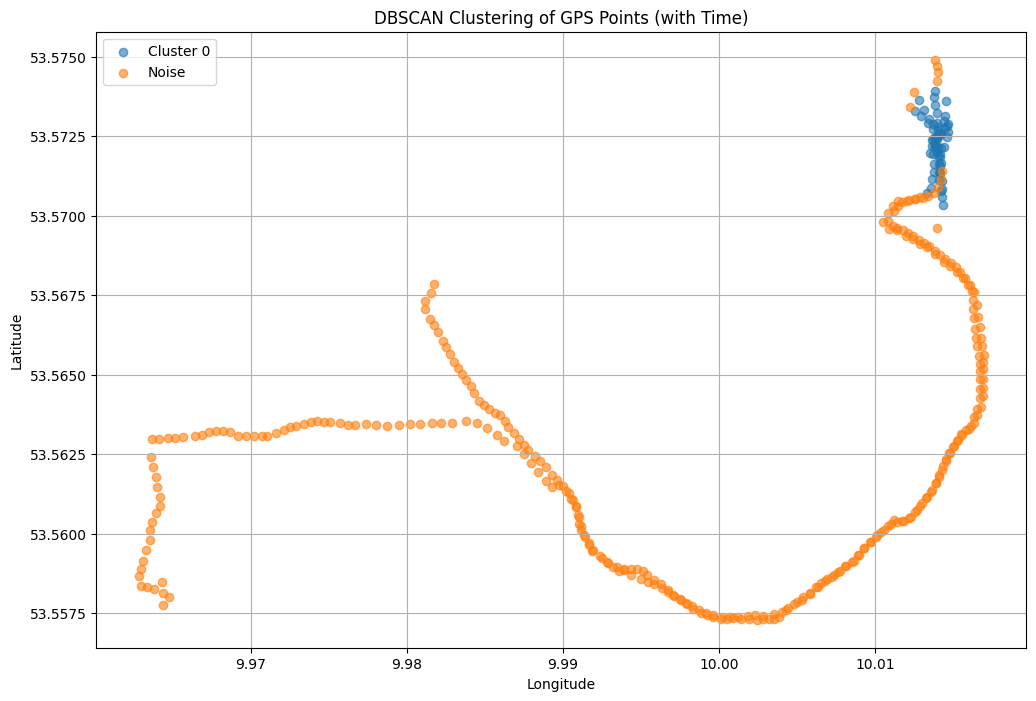

In [4]:
import json
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Reload the data
file_path = 'stop_phase_gps_data.json'
with open(file_path, "r") as f:
    data = json.load(f)

# Convert to DataFrame
df = pd.DataFrame(data)
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['time_seconds'] = (df['timestamp'] - df['timestamp'].min()).dt.total_seconds()

# Feature array
X = df[['latitude', 'longitude', 'time_seconds']].to_numpy()

# DBSCAN parameters
eps = 0.0009
# roughly 50 meters in lat/lon degrees
time_eps = 9000  # 15 minutes in seconds

# Normalize time feature to match spatial scale (optional and simple scaling here)
X[:, 2] = X[:, 2] * 6/ time_eps * eps

# Apply DBSCAN
dbscan = DBSCAN(eps=eps, min_samples=10)
df['cluster'] = dbscan.fit_predict(X)

# Visualize
plt.figure(figsize=(12, 8))
unique_clusters = set(df['cluster'])
for cluster in unique_clusters:
    cluster_points = df[df['cluster'] == cluster]
    plt.scatter(cluster_points['longitude'], cluster_points['latitude'], label=f'Cluster {cluster}' if cluster != -1 else 'Noise', alpha=0.6)

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('DBSCAN Clustering of GPS Points (with Time)')
plt.legend()
plt.grid(True)
plt.show()


In [5]:
import json
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Reload the data
file_path = 'stop_phase_gps_data.json'
with open(file_path, "r") as f:
    data = json.load(f)

# Convert to DataFrame
df = pd.DataFrame(data)
# Convert timestamp from epoch (UTC) to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
df['time_seconds'] = (df['timestamp'] - df['timestamp'].min()).dt.total_seconds()

# Feature array
X = df[['latitude', 'longitude', 'time_seconds']].to_numpy()

# DBSCAN parameters
eps = 0.0009
# roughly 50 meters in lat/lon degrees
time_eps = 9000  # 15 minutes in seconds

# Normalize time feature to match spatial scale (optional and simple scaling here)
X[:, 2] = X[:, 2] * 6/ time_eps * eps

# Apply DBSCAN
dbscan = DBSCAN(eps=eps, min_samples=10)
df['cluster'] = dbscan.fit_predict(X)

# Visualize
plt.figure(figsize=(12, 8))
unique_clusters = set(df['cluster'])
for cluster in unique_clusters:
    cluster_points = df[df['cluster'] == cluster]
    plt.scatter(cluster_points['longitude'], cluster_points['latitude'], label=f'Cluster {cluster}' if cluster != -1 else 'Noise', alpha=0.6)

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('DBSCAN Clustering of GPS Points (with Time)')
plt.legend()
plt.grid(True)
plt.show()

ValueError: non convertible value 2025-04-01T07:45:06 with the unit 's', at position 0

In [ ]:
# Load the data
file_path = 'stop_phase_gps_data.json'
with open(file_path, "r") as f:
    data = json.load(f)

# Convert to DataFrame and preprocess
df = pd.DataFrame(data)
# Convert timestamp from epoch (UTC) to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
df = df.sort_values('timestamp').reset_index(drop=True) # Ensure data is sorted

df.head()

In [ ]:
# Calculate median of the next `median_n` rows
median_n = 18
df['next_n_median_longitude'] = df['longitude'].apply(
    lambda x: None  # placeholder, will be overwritten
)
df['next_n_median_latitude'] = df['latitude'].apply(
    lambda x: None  # placeholder, will be overwritten
)

for i in range(len(df)):
    df.loc[i, 'next_n_median_longitude'] = df['longitude'].iloc[i+1:i+1+median_n].median()
    df.loc[i, 'next_n_median_latitude'] = df['latitude'].iloc[i+1:i+1+median_n].median()
print(median_n)
df.tail()



In [ ]:
# --- Configuration ---
stop_distance_threshold_meters = 140  # Max distance (meters) between points to be considered 'stopped'
min_stop_duration_seconds = 10 * 60 # Minimum duration (seconds) for a stop to be cleaned

# --- Algorithm ---
cleaned_data = []
i = 0
n = len(df)

while i < n:
    current_point = df.iloc[i]
    
    # Start checking for a stop from the next point
    j = i + 1
    stop_candidates = [current_point] # Current point is always the start of a potential stop/movement
    
    # Find consecutive points within the distance threshold of the *start* point
    while j < n:
        next_point = df.iloc[j]
        
        distance = haversine(
            (current_point['next_n_median_latitude'], current_point['next_n_median_longitude']),
            (next_point['next_n_median_latitude'], next_point['next_n_median_longitude']),
            unit=Unit.METERS
        )
        
        if distance < stop_distance_threshold_meters:
            stop_candidates.append(next_point)
            j += 1
        else:
            break # Movement detected, stop sequence ends
            
    # Evaluate the identified sequence (stop_candidates)
    if len(stop_candidates) > 1: # We found at least one subsequent point that was 'stopped'
        start_time = stop_candidates[0]['timestamp']
        end_time = stop_candidates[-1]['timestamp']
        duration = (end_time - start_time).total_seconds()
        
        if duration >= min_stop_duration_seconds:
            # Long stop: Keep only the first point
            cleaned_data.append(stop_candidates[0])
            # Move the main index past all points in this long stop
            i = j 
        else:
            # Short stop or just noise: Keep all points in the sequence
            cleaned_data.extend(stop_candidates)
            # Move the main index past all points in this sequence
            i = j 
    else: 
        # No stop detected starting at current_point, just keep current_point and move to the next
        cleaned_data.append(current_point)
        i += 1

# Create the final cleaned DataFrame
cleaned_df = pd.DataFrame(cleaned_data).reset_index(drop=True)

In [ ]:
# Display results
print(f"Original number of points: {len(df)}")
print(f"Cleaned number of points: {len(cleaned_df)}")
cleaned_df.tail()

In [ ]:
center = [df['latitude'].mean(), df['longitude'].mean()]

In [ ]:
m = folium.Map(location=center, zoom_start=14)
# Add points to the map
for idx, row in df.iterrows():
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        popup=row.get('label', f"Point {idx}"),
        tooltip=row.get('label', f"Point {idx}")
    ).add_to(m)
df_median_cleaned = df.dropna(subset=['next_n_median_latitude', 'next_n_median_longitude'])
for idx, row in df_median_cleaned.iterrows():
    folium.Marker(
        location=[row['next_n_median_latitude'], row['next_n_median_longitude']],
        popup=row.get('label', f"Median Point {idx}"),
        icon=folium.Icon(color='red', icon='info-sign'),
        tooltip=row.get('label', f"Median Point {idx}")
    ).add_to(m)
coordinates = df[['latitude', 'longitude']].values.tolist()
folium.PolyLine(locations=coordinates, color='blue', weight=3).add_to(m)
cleaned_coordinates = cleaned_df[['latitude','longitude']].values.tolist()
folium.PolyLine(locations=cleaned_coordinates, color='purple', weight=3).add_to(m)
m

In [ ]:
m = folium.Map(location=center, zoom_start=14)


for idx, row in cleaned_df.iterrows():
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        popup=row.get('label', f"Median Point {idx}"),
        icon=folium.Icon(color='red', icon='info-sign'),
        tooltip=row.get('label', f"Median Point {idx}")
    ).add_to(m)
cleaned_coordinates = cleaned_df[['latitude','longitude']].values.tolist()
folium.PolyLine(locations=cleaned_coordinates, color='purple', weight=3).add_to(m)
m

In [ ]:
import json
import pandas as pd
import os
import folium
from folium.plugins import HeatMap
from datetime import datetime

# Function to load JSONL files
def load_jsonl(file_path):
    data = []
    with open(file_path, 'r') as f:
        for line in f:
            try:
                data.append(json.loads(line))
            except json.JSONDecodeError:
                continue
    return data

# Load GPS logs from the gps_logs directory
log_files = [os.path.join('gps_logs', f) for f in os.listdir('gps_logs') if f.endswith('.jsonl') and not f.endswith('_test.jsonl')]
print(f"Found {len(log_files)} log files: {log_files}")

# Store data by date for visualization
all_gps_data = {}

for file_path in log_files:
    data = load_jsonl(file_path)
    date = os.path.basename(file_path).split('_')[0]
    all_gps_data[date] = pd.DataFrame(data)
    
    # Convert timestamp to datetime - now handling epoch timestamps (UTC)
    if 'timestamp' in all_gps_data[date].columns:
        all_gps_data[date]['datetime'] = pd.to_datetime(all_gps_data[date]['timestamp'], unit='s')
    
    # Check for lat/lon column names
    lat_col = 'latitude' if 'latitude' in all_gps_data[date].columns else 'lat'
    lon_col = 'longitude' if 'longitude' in all_gps_data[date].columns else 'lon'
    
    print(f"File: {file_path}, Points: {len(data)}, Columns: {all_gps_data[date].columns.tolist()}")

# Display a map for each date
for date, df in all_gps_data.items():
    print(f"\nVisualization for date: {date}")
    
    # Identify lat/lon column names
    lat_col = 'latitude' if 'latitude' in df.columns else 'lat'
    lon_col = 'longitude' if 'longitude' in df.columns else 'lon'
    
    # Calculate map center
    center = [df[lat_col].mean(), df[lon_col].mean()]
    
    # Create map
    m = folium.Map(location=center, zoom_start=14)
    
    # Create path
    coordinates = df[[lat_col, lon_col]].values.tolist()
    folium.PolyLine(locations=coordinates, color='blue', weight=3, 
                   popup=f"GPS track for {date}").add_to(m)
    
    # Add start and end markers
    folium.Marker(
        location=[df[lat_col].iloc[0], df[lon_col].iloc[0]],
        popup="Start",
        icon=folium.Icon(color='green', icon='play'),
    ).add_to(m)
    
    folium.Marker(
        location=[df[lat_col].iloc[-1], df[lon_col].iloc[-1]],
        popup="End",
        icon=folium.Icon(color='red', icon='stop'),
    ).add_to(m)
    
    # Create heat map
    HeatMap(
        data=df[[lat_col, lon_col]].values.tolist(),
        radius=15,
        blur=10
    ).add_to(m)
    
    # Display the map
    display(m)

Found 3 log files: ['gps_logs/2025-04-10_locations.jsonl', 'gps_logs/2025-04-11_locations.jsonl', 'gps_logs/2025-04-13_locations.jsonl']
File: gps_logs/2025-04-10_locations.jsonl, Points: 108, Columns: ['lat', 'satellites_used', 'device_id', 'battery', 'lon', 'quality', 'time', 'timestamp', 'cog', 'ele', 'sog', 'time_raw', 'datetime']
File: gps_logs/2025-04-11_locations.jsonl, Points: 4762, Columns: ['lat', 'satellites_used', 'device_id', 'battery', 'lon', 'quality', 'time', 'timestamp', 'cog', 'ele', 'sog', 'time_raw', 'datetime']
File: gps_logs/2025-04-13_locations.jsonl, Points: 2842, Columns: ['lat', 'time', 'cog', 'battery', 'satellites_used', 'timestamp', 'sog', 'quality', 'device_id', 'lon', 'cycle_time', 'ele', 'time_raw', 'datetime']

Visualization for date: 2025-04-10



Visualization for date: 2025-04-11



Visualization for date: 2025-04-13


In [ ]:
import json
import pandas as pd
import os
import folium
from folium.plugins import HeatMap
from datetime import datetime

# Function to load JSONL files
def load_jsonl(file_path):
    data = []
    with open(file_path, 'r') as f:
        for line in f:
            try:
                data.append(json.loads(line))
            except json.JSONDecodeError:
                continue
    return data

raw = '/Users/ralf.sigmund/GitHub/mp_m5_fahrtenbuch/test/gps_logs/2025-04-11_locations.jsonl'
cleaned = '/Users/ralf.sigmund/GitHub/mp_m5_fahrtenbuch/test/gps_logs/2025-04-11_locations_cleaned.jsonl'
# Store data by date for visualization
data_raw = pd.DataFrame(load_jsonl(raw))
data_cleaned = pd.DataFrame(load_jsonl(cleaned))
# Convert timestamp to datetime - now handling epoch timestamps (UTC)
def convert_timestamp(data):
    if 'timestamp' in data.columns:
        data['datetime'] = pd.to_datetime(data['timestamp'], unit='s',utc=True)
        data['datetime'] = data['datetime'].dt.tz_convert('Europe/Berlin')
        data['sog_kmh'] = data['sog'] * 3.6
convert_timestamp(data_raw)
convert_timestamp(data_cleaned)


# Merge with indicator to identify the source of each row
merged = data_raw.merge(data_cleaned.drop_duplicates(subset=['timestamp']), on=['lat', 'lon', 'timestamp','sog'], how='left', indicator=True)
# Filter rows that are only in DataFrame 'a'
data_raw_only = merged[merged['_merge'] == 'left_only'].drop(columns=['_merge'])
convert_timestamp(data_raw_only)
print(f"number of items in cleaned {len(data_cleaned)}")
print(f"number of items in raw {len(data_raw)}")
print(f"number of items only in raw {len(data_raw_only)}")
pd.set_option('display.max_columns', None)
data_raw_only.tail()

number of items in cleaned 3109
number of items in raw 4762
number of items only in raw 1643


,lat,satellites_used_x,device_id_x,battery_x,lon,quality_x,time_x,timestamp,cog_x,ele_x,sog,time_raw_x,datetime_x,sog_kmh_x,satellites_used_y,device_id_y,battery_y,quality_y,time_y,cog_y,ele_y,time_raw_y,datetime_y,sog_kmh_y,datetime,sog_kmh
4751,50.6517,17,vehicle_01,100,5.473353,1,2025-04-11T21:30:09 MESZ,1744396209,0.0,96.61,0.17,"[2025, 4, 11, 19, 30, 9]",2025-04-11 20:30:09+02:00,0.612,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,2025-04-11 20:30:09+02:00,0.612
4752,50.6517,18,vehicle_01,100,5.473353,1,2025-04-11T21:30:17 MESZ,1744396217,0.0,96.61,0.33,"[2025, 4, 11, 19, 30, 17]",2025-04-11 20:30:17+02:00,1.188,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,2025-04-11 20:30:17+02:00,1.188
4753,50.6517,17,vehicle_01,100,5.473353,1,2025-04-11T21:30:22 MESZ,1744396222,0.0,96.61,0.34,"[2025, 4, 11, 19, 30, 22]",2025-04-11 20:30:22+02:00,1.224,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,2025-04-11 20:30:22+02:00,1.224
4754,50.6517,19,vehicle_01,100,5.473353,1,2025-04-11T21:30:28 MESZ,1744396228,0.0,96.61,0.97,"[2025, 4, 11, 19, 30, 28]",2025-04-11 20:30:28+02:00,3.492,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,2025-04-11 20:30:28+02:00,3.492
4755,50.6517,21,vehicle_01,100,5.473353,1,2025-04-11T21:30:36 MESZ,1744396236,0.0,96.61,0.65,"[2025, 4, 11, 19, 30, 36]",2025-04-11 20:30:36+02:00,2.340,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,2025-04-11 20:30:36+02:00,2.340


In [ ]:
# Calculate time differences in seconds
data_raw['time_gap'] = data_raw['datetime'].diff().dt.total_seconds()
data_cleaned['time_gap'] = data_cleaned['datetime'].diff().dt.total_seconds()
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(data_raw['datetime'], data_raw['time_gap'], marker='o', linestyle='-')
plt.plot(data_cleaned['datetime'], data_cleaned['time_gap'], marker='x', linestyle='-')
plt.title('Time Gaps Between Consecutive Timestamps')
plt.xlabel('Timestamp (Europe/Berlin)')
plt.ylabel('Gap Duration (seconds)')
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import json
import boto3
import os
from boto3.dynamodb.conditions import Key
from decimal import Decimal
from datetime import datetime, timedelta, UTC
import math
import statistics
from typing import List, Dict, Any, Tuple, Optional
import traceback

# Database setup
dynamodb = boto3.resource("dynamodb")
locations_table = dynamodb.Table(os.environ.get("DYNAMODB_LOCATIONS_TABLE", "gps-tracking-service-dev-locations-v2"))
logs_table = dynamodb.Table(os.environ.get("DYNAMODB_LOCATIONS_LOGS_TABLE", "gps-tracking-service-dev-locations-logs-v2"))

# Configuration parameters
SESSION_GAP_MINUTES = 60  # Gap in minutes to consider a new session
MIN_SESSION_DURATION_MINUTES = 5  # Minimum session duration in minutes
MIN_SESSION_DISTANCE_METERS = 500  # Minimum distance for a valid session
MAX_DAYS_TO_SCAN = 30  # Maximum number of days to look back
MAX_SESSIONS_TO_RETURN = 10  # Maximum number of sessions to return

def decimal_default(obj):
    if isinstance(obj, Decimal):
        return float(obj)
    raise TypeError

def haversine(lat1, lon1, lat2, lon2):
    R = 6371000  # Earth radius in meters
    phi1, phi2 = math.radians(lat1), math.radians(lat2)
    dphi = math.radians(lat2 - lat1)
    dlambda = math.radians(lon2 - lon1)
    a = math.sin(dphi / 2) ** 2 + math.cos(phi1) * math.cos(phi2) * math.sin(dlambda / 2) ** 2
    return R * 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

def clean_phantom_locations(locations: List[Dict[str, Any]]) -> List[Dict[str, Any]]:
    """Remove phantom location fixes when vehicle is stopped - same as in get_dynamic_location_history"""
    # Configuration parameters
    STOP_DISTANCE_THRESHOLD = 140    # Max distance (meters) between points to be considered 'stopped'
    MIN_STOP_DURATION_SECONDS = 10 * 60  # Minimum duration (seconds) for a stop to be cleaned
    MEDIAN_WINDOW_SIZE = 18  # Number of points to consider for median calculation
    
    if len(locations) < 3:
        return locations  # Not enough data points to process
    
    # Sort by timestamp ascending
    sorted_locations = sorted(locations, key=lambda x: x['timestamp'])
    
    # Calculate median of next n points for each location
    for i in range(len(sorted_locations)):
        end_idx = min(i + 1 + MEDIAN_WINDOW_SIZE, len(sorted_locations))
        if i + 1 < end_idx:  # At least one point ahead
            future_points = sorted_locations[i+1:end_idx]
            
            # Calculate median position
            future_lats = [float(loc['lat']) for loc in future_points]
            future_lngs = [float(loc['lon']) for loc in future_points]
            
            if future_lats and future_lngs:
                sorted_locations[i]['next_n_median_latitude'] = statistics.median(future_lats)
                sorted_locations[i]['next_n_median_longitude'] = statistics.median(future_lngs)
    
    # Initialize cleaned data list and processing index
    cleaned_data = []
    i = 0
    n = len(sorted_locations)
    
    while i < n:
        current_point = sorted_locations[i]
        
        # Start checking for a stop from the next point
        j = i + 1
        stop_candidates = [current_point]  # Current point is always the start of a potential stop/movement
        
        # Find consecutive points within the distance threshold of the start point's next median
        while j < n:
            next_point = sorted_locations[j]
            
            # Skip points without median calculations (typically points near the end)
            if ('next_n_median_latitude' not in current_point or 
                'next_n_median_longitude' not in current_point or
                'next_n_median_latitude' not in next_point or
                'next_n_median_longitude' not in next_point):
                break
            
            distance = haversine(
                current_point['next_n_median_latitude'], current_point['next_n_median_longitude'],
                next_point['next_n_median_latitude'], next_point['next_n_median_longitude']
            )
            
            if distance < STOP_DISTANCE_THRESHOLD:
                stop_candidates.append(next_point)
                j += 1
            else:
                break  # Movement detected, stop sequence ends
        
        # Evaluate the identified sequence (stop_candidates)
        if len(stop_candidates) > 1:  # We found at least one subsequent point that was 'stopped'
            start_time = datetime.fromtimestamp(int(stop_candidates[0]['timestamp']))
            end_time = datetime.fromtimestamp(int(stop_candidates[-1]['timestamp']))
            duration = (end_time - start_time).total_seconds()
            
            if duration >= MIN_STOP_DURATION_SECONDS:
                # Long stop: Keep only the first point and mark it as a stop point
                stop_candidate = stop_candidates[0].copy()
                stop_candidate['segment_type'] = 'stopped'
                stop_candidate['stop_duration_seconds'] = duration
                cleaned_data.append(stop_candidate)
                # Move the main index past all points in this long stop
                i = j
            else:
                # Short stop or just noise: Keep all points in the sequence as movement
                for point in stop_candidates:
                    point_copy = point.copy()
                    point_copy['segment_type'] = 'moving'
                    cleaned_data.append(point_copy)
                # Move the main index past all points in this sequence
                i = j
        else:
            # No stop detected starting at current_point, mark as moving
            point_copy = current_point.copy()
            point_copy['segment_type'] = 'moving'
            cleaned_data.append(point_copy)
            i += 1
    
    # Remove the temporary median fields before returning
    for loc in cleaned_data:
        if 'next_n_median_latitude' in loc:
            del loc['next_n_median_latitude']
        if 'next_n_median_longitude' in loc:
            del loc['next_n_median_longitude']
    
    return cleaned_data

def fetch_vehicle_locations(vehicle_id: str, start_date: Optional[datetime] = None, end_date: Optional[datetime] = None) -> List[Dict[str, Any]]:
    """Fetch locations for a vehicle within a time range"""
    try:
        print(f"Fetching data for vehicle {vehicle_id}")
        
        # Define query parameters
        query_params = {
            'KeyConditionExpression': Key('id').eq(vehicle_id)
        }
        
        # Add time range condition if provided
        if start_date and end_date:
            start_timestamp = int(start_date.timestamp())
            end_timestamp = int(end_date.timestamp())
            query_params['KeyConditionExpression'] = Key('id').eq(vehicle_id) & Key('timestamp').between(start_timestamp, end_timestamp)
        
        # Query the locations table
        response = locations_table.query(**query_params)
        items = response.get('Items', [])
        print(f"Found {len(items)} location data points")
        
        # Handle pagination if necessary
        while 'LastEvaluatedKey' in response:
            response = locations_table.query(
                **query_params,
                ExclusiveStartKey=response['LastEvaluatedKey']
            )
            new_items = response.get('Items', [])
            items.extend(new_items)
            print(f"Retrieved additional {len(new_items)} points, total: {len(items)}")
        
        return items
    except Exception as e:
        print(f"Error fetching vehicle locations: {str(e)}")
        print(traceback.format_exc())
        return []

def is_time_in_existing_log(vehicle_id: str, timestamp: str) -> bool:
    """Check if a timestamp falls within any existing driver's log entry"""
    try:
        # Scan all log entries (in a production app, you'd use a GSI or more optimized approach)
        response = logs_table.scan()
        items = response.get('Items', [])
        
        # Handle pagination
        while 'LastEvaluatedKey' in response:
            response = logs_table.scan(ExclusiveStartKey=response['LastEvaluatedKey'])
            items.extend(response.get('Items', []))
        
        # Check if the timestamp falls within any log entry's time range
        # and belongs to the same vehicle
        for item in items:
            start_time = item.get('startTime')
            end_time = item.get('endTime')
            log_vehicle_id = item.get('vehicleId')  
            
            if start_time and end_time and log_vehicle_id == vehicle_id:
                if start_time <= timestamp <= end_time:
                    print(f"existing log {item} for timestamp {timestamp}")
                    return True
        
        return False
    except Exception as e:
        print(f"Error checking existing logs: {str(e)}")
        return False

def identify_sessions(vehicle_id: str, locations: List[Dict[str, Any]]) -> List[Dict[str, Any]]:
    """Identify distinct sessions from locations data"""
    if not locations:
        return []
    
    # Sort locations by timestamp
    sorted_locations = sorted(locations, key=lambda x: x['timestamp'])
    
    # Apply phantom cleanup to identify stops vs moving segments
    # cleaned_locations = clean_phantom_locations(sorted_locations)
    cleaned_locations = sorted_locations
    # Find session boundaries
    sessions = []
    current_session = []
    last_timestamp = None
    
    for location in cleaned_locations:
        current_timestamp = datetime.fromtimestamp(int(location['timestamp']))
        
        # Check if this point starts a new session
        if last_timestamp and (current_timestamp - last_timestamp).total_seconds() > SESSION_GAP_MINUTES * 60:
            # Process completed session
            print(f"ending session due to gap {(current_timestamp - last_timestamp).total_seconds()} current:{current_timestamp} prev:{last_timestamp}")
            if current_session:
                session_info = process_session(vehicle_id, current_session)
                if session_info:
                    sessions.append(session_info)
                current_session = []
        
        # Add point to current session
        current_session.append(location)
        last_timestamp = current_timestamp
    
    # Process the last session
    if current_session:
        session_info = process_session(vehicle_id, current_session)
        if session_info:
            sessions.append(session_info)
    
    return sessions

def process_session(vehicle_id: str, session_points: List[Dict[str, Any]]) -> Optional[Dict[str, Any]]:
    """Process a session and calculate relevant metrics"""
    if not session_points or len(session_points) < 2:
        return None
    
    # Sort by timestamp to ensure correct order
    session_points = sorted(session_points, key=lambda x: x['timestamp'])
    
    start_point = session_points[0]
    end_point = session_points[-1]
    start_time = datetime.fromtimestamp(int(start_point['timestamp']))
    end_time = datetime.fromtimestamp(int(end_point['timestamp']))
    
    # Calculate duration in minutes
    duration = (end_time - start_time).total_seconds() / 60
    
    # Skip sessions that are too short
    if duration < MIN_SESSION_DURATION_MINUTES:
        return None
    
    # Calculate distance and movement metrics
    total_distance = 0
    moving_points = []
    stopped_points = []
    moving_time = 0
    stopped_time = 0
    
    for i in range(1, len(session_points)):
        prev = session_points[i-1]
        curr = session_points[i]
        
        # Calculate distance for this segment
        segment_distance = haversine(
            float(prev['lat']), float(prev['lon']), 
            float(curr['lat']), float(curr['lon'])
        )
        
        total_distance += segment_distance
        
        # Track moving vs stopped points
        if curr.get('segment_type') == 'stopped':
            stopped_points.append(curr)
            if curr.get('stop_duration_seconds'):
                stopped_time += float(curr['stop_duration_seconds']) / 60  # Convert to minutes
        else:
            moving_points.append(curr)
            prev_time = datetime.fromtimestamp(int(prev['timestamp']))
            curr_time = datetime.fromtimestamp(int(curr['timestamp']))
            moving_time += (curr_time - prev_time).total_seconds() / 60  # Convert to minutes
    
    # Skip sessions with very little movement
    if total_distance < MIN_SESSION_DISTANCE_METERS:
        print(f"skipping session with dist {total_distance} from {start_time} to {end_time}")
        return None
    
    # Calculate average speed (km/h) during moving segments
    avg_speed = 0
    if moving_time > 0:
        # Convert: meters/minute to km/hour
        avg_speed = (total_distance / 1000) / (moving_time / 60)
    
    # Generate a unique session ID
    session_id = f"session_{start_time.timestamp():.0f}_{vehicle_id}"
    
    # Check if this session is already covered by an existing driver's log
    if is_time_in_existing_log(vehicle_id, start_point['timestamp']) or is_time_in_existing_log(vehicle_id, end_point['timestamp']):
        print(f"skipping session overlapping from {start_time} to {end_time}")
        # Skip this session as it overlaps with an existing log
        return None
    
    # Create session info object
    session_info = {
        'id': session_id,
        'vehicleId': vehicle_id,
        'startTime': start_point['timestamp'],
        'endTime': end_point['timestamp'],
        'duration': duration,
        'distance': total_distance,
        'movingTime': moving_time,
        'stoppedTime': stopped_time,
        'avgSpeed': avg_speed,
        'numPoints': len(session_points),
        'numStops': len(stopped_points),
        'startLat': float(start_point['lat']),
        'startLon': float(start_point['lon']),
        'endLat': float(end_point['lat']),
        'endLon': float(end_point['lon']),
    }
    
    return session_info

def handler(event, context):
    try:
        # Extract query parameters
        query_params = event.get('queryStringParameters', {}) or {}
        vehicle_id = query_params.get('vehicle_id', 'vehicle_01')
        days_to_scan = min(int(query_params.get('days', '7')), MAX_DAYS_TO_SCAN)
        
        # Calculate date range
        end_date = datetime.now(tz=UTC)
        start_date = end_date - timedelta(days=days_to_scan)
        
        # Fetch location data for the vehicle
        locations = fetch_vehicle_locations(vehicle_id, start_date, end_date)
        
        if not locations:
            return {
                "statusCode": 404,
                "headers": {
                    "Content-Type": "application/json",
                    "Access-Control-Allow-Origin": "*"
                },
                "body": json.dumps({"message": "No location data found for the vehicle in the specified time range"})
            }
        
        # Identify sessions
        sessions = identify_sessions(vehicle_id, locations)
        
        # Sort by start time (newest first)
        sessions = sorted(sessions, key=lambda x: x['startTime'], reverse=True)
        
        # Limit the number of sessions returned
        sessions = sessions[:MAX_SESSIONS_TO_RETURN]
        
        # Format response
        response = {
            "vehicle_id": vehicle_id,
            "scan_period": {
                "start": start_date.isoformat(),
                "end": end_date.isoformat(),
                "days": days_to_scan
            },
            "sessions": sessions
        }
        
        return {
            "statusCode": 200,
            "headers": {
                "Content-Type": "application/json",
                "Access-Control-Allow-Origin": "*"
            },
            "body": json.dumps(response, default=decimal_default)
        }
        
    except Exception as e:
        print(f"Error processing request: {str(e)}")
        traceback.print_exc()
        return {
            "statusCode": 500,
            "headers": {
                "Content-Type": "application/json",
                "Access-Control-Allow-Origin": "*"
            },
            "body": json.dumps({"error": str(e)})
        }
scan_result=handler({},None)

Fetching data for vehicle vehicle_01
Found 3862 location data points
ending session due to gap 32420.0 current:2025-04-11 08:49:13 prev:2025-04-10 23:48:53
skipping session with dist 82.78376324960949 from 2025-04-10 22:48:53 to 2025-04-10 23:48:53
ending session due to gap 7749.0 current:2025-04-11 11:53:42 prev:2025-04-11 09:44:33
skipping session with dist 305.8956023170826 from 2025-04-11 08:49:13 to 2025-04-11 09:44:33
ending session due to gap 135205.0 current:2025-04-13 10:30:48 prev:2025-04-11 20:57:23
ending session due to gap 24361.0 current:2025-04-13 17:33:52 prev:2025-04-13 10:47:51
skipping session with dist 33.1768100031574 from 2025-04-13 10:30:48 to 2025-04-13 10:47:51
ending session due to gap 55658.0 current:2025-04-14 17:54:37 prev:2025-04-14 02:26:59
ending session due to gap 163321.0 current:2025-04-16 15:56:56 prev:2025-04-14 18:34:55
skipping session with dist 172.55965566859496 from 2025-04-14 17:54:37 to 2025-04-14 18:34:55
skipping session with dist 67.097645

In [ ]:
import json

data = json.loads(scan_result['body'])
sessions = data['sessions']
from datetime import datetime
import folium
from folium.plugins import TimestampedGeoJson

features = []

for session in sessions:
    start_coords = [session['startLon'], session['startLat']]
    end_coords = [session['endLon'], session['endLat']]
    coordinates = [start_coords, end_coords]

    # Convert start and end times from Unix timestamp to ISO format
    start_time = datetime.utcfromtimestamp(session['startTime']).isoformat() + 'Z'
    end_time = datetime.utcfromtimestamp(session['endTime']).isoformat() + 'Z'
    times = [start_time, end_time]

    feature = {
        'type': 'Feature',
        'geometry': {
            'type': 'LineString',
            'coordinates': coordinates
        },
        'properties': {
            'times': times,
            'popup': f"Session ID: {session['id']} {start_time} to {end_time}",
            'style': {'color': 'blue'}
        }
    }
    features.append(feature)
# Calculate the center of the map
all_lats = [session['startLat'] for session in sessions] + [session['endLat'] for session in sessions]
all_lons = [session['startLon'] for session in sessions] + [session['endLon'] for session in sessions]
center_lat = sum(all_lats) / len(all_lats)
center_lon = sum(all_lons) / len(all_lons)

# Initialize the map
m = folium.Map(location=[center_lat, center_lon], zoom_start=6)

# Add the TimestampedGeoJson layer
TimestampedGeoJson(
    {
        'type': 'FeatureCollection',
        'features': features,
    },
    period='PT1M',
    add_last_point=True,
    auto_play=True,
    loop=False,
    max_speed=1,
    loop_button=True,
    date_options='YYYY-MM-DD HH:mm:ss',
    time_slider_drag_update=True
).add_to(m)

# Display the map
m


/var/folders/54/b5xwty4d3k76nwf58jmd6g9c0000gp/T/ipykernel_37059/3302914605.py:17: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  start_time = datetime.utcfromtimestamp(session['startTime']).isoformat() + 'Z'
/var/folders/54/b5xwty4d3k76nwf58jmd6g9c0000gp/T/ipykernel_37059/3302914605.py:18: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  end_time = datetime.utcfromtimestamp(session['endTime']).isoformat() + 'Z'


In [ ]:
# analyze on-device data-cleaning



date = os.path.basename(raw).split('_')[0]

def check(file_path, df):    
    print(f"File: {file_path}, Points: {len(df)}, Columns: {df.columns.tolist()}")
check(raw,data_raw)
check(cleaned,data_cleaned)

# Display a map for each date
def display_map(df):
    print(f"\nVisualization for date: {date}")
    lat_col = 'lat'
    lon_col = 'lon'
    
    # Calculate map center
    center = [df[lat_col].mean(), df[lon_col].mean()]
    
    # Create map
    m = folium.Map(location=center, zoom_start=14)
    
    # Create path
    coordinates = df[[lat_col, lon_col]].values.tolist()
    folium.PolyLine(locations=coordinates, color='blue', weight=3, 
                   popup=f"GPS track for {date}").add_to(m)
    
    # Add start and end markers
    folium.Marker(
        location=[df[lat_col].iloc[0], df[lon_col].iloc[0]],
        popup="Start",
        icon=folium.Icon(color='green', icon='play'),
    ).add_to(m)
    
    folium.Marker(
        location=[df[lat_col].iloc[-1], df[lon_col].iloc[-1]],
        popup="End",
        icon=folium.Icon(color='red', icon='stop'),
    ).add_to(m)
    
    # Create heat map
    HeatMap(
        data=df[[lat_col, lon_col]].values.tolist(),
        radius=15,
        blur=10
    ).add_to(m)
    
def create_combined_visualization(raw_df,cleaned_df,raw_only_df):
        print(f"\nCombined Visualization for date: {date}")
        lat_col = 'lat'
        lon_col = 'lon'
        center = [raw_df[lat_col].mean(), raw_df[lon_col].mean()]
        m = folium.Map(location=center, zoom_start=12)
        
       
        # Create path
        raw_coordinates = raw_df[[lat_col, lon_col]].values.tolist()
        cleaned_coordinates = cleaned_df[[lat_col, lon_col]].values.tolist()
        raw_only_coordinates = raw_only_df[[lat_col,lon_col]].values.tolist()
        folium.PolyLine(
            locations=raw_coordinates,
            color='blue',
            weight=3,
            popup=f"raw GPS track for {date}",
            tooltip=f"Raw Date: {date}"
        ).add_to(m)
        # Add start marker
        folium.Marker(
            location=[raw_df[lat_col].iloc[0], raw_df[lon_col].iloc[0]],
            popup=f"Raw Start - {raw_df['datetime'].iloc[0]}",
            tooltip=f"Raw Start - {raw_df['datetime'].iloc[0]}",
            icon=folium.Icon(color='blue', icon='play'),
        ).add_to(m)
        folium.PolyLine(
            locations=cleaned_coordinates,
            color='red',
            weight=3,
            popup=f"cleaned GPS track for {date}",
            tooltip=f"Cleaned Date: {date}"
        ).add_to(m)
        folium.Marker(
            location=[cleaned_df[lat_col].iloc[0], cleaned_df[lon_col].iloc[0]],
            popup=f"Cleaned Start - {cleaned_df['datetime'].iloc[0]}",
            tooltip=f"Cleaned Start - {cleaned_df['datetime'].iloc[0]}",
            icon=folium.Icon(color='red', icon='play'),
        ).add_to(m)

        

        for idx, row in raw_only_df.iterrows():
            folium.Marker(
                location=[row[lat_col], row[lon_col]],         
                icon=folium.Icon(color='blue', icon='info-sign'),
                popup=f"{row['datetime']} speed: {row['sog_kmh']}",
        ).add_to(m)
        m.fit_bounds(raw_coordinates)
    
        return m 
        
display_map(data_raw)
display_map(data_cleaned)
create_combined_visualization(data_raw,data_cleaned,data_raw_only)

File: /Users/ralf.sigmund/GitHub/mp_m5_fahrtenbuch/test/gps_logs/2025-04-11_locations.jsonl, Points: 4762, Columns: ['lat', 'satellites_used', 'device_id', 'battery', 'lon', 'quality', 'time', 'timestamp', 'cog', 'ele', 'sog', 'time_raw', 'datetime', 'sog_kmh']
File: /Users/ralf.sigmund/GitHub/mp_m5_fahrtenbuch/test/gps_logs/2025-04-11_locations_cleaned.jsonl, Points: 3109, Columns: ['lat', 'satellites_used', 'device_id', 'battery', 'lon', 'quality', 'time', 'timestamp', 'cog', 'ele', 'sog', 'time_raw', 'datetime', 'sog_kmh']

Visualization for date: 2025-04-11

Visualization for date: 2025-04-11

Combined Visualization for date: 2025-04-11


In [ ]:
# Create a combined visualization of all GPS data
# This helps to identify patterns across different days

def create_combined_visualization(all_data):
    # Create a list of all dataframes with consistent column names
    combined_dfs = []
    
    for date, df in all_data.items():
        # Create a copy with consistent column names
        df_copy = df.copy()
        
        # Standardize lat/lon column names
        if 'lat' in df_copy.columns and 'latitude' not in df_copy.columns:
            df_copy['latitude'] = df_copy['lat'] 
        if 'lon' in df_copy.columns and 'longitude' not in df_copy.columns:
            df_copy['longitude'] = df_copy['lon']
            
        # Add date information
        df_copy['source_date'] = date
        
        # Add to combined list
        combined_dfs.append(df_copy)
    
    # Combine all dataframes
    if combined_dfs:
        combined_df = pd.concat(combined_dfs, ignore_index=True)
        
        # Calculate the overall center
        center_lat = combined_df['latitude'].mean() if 'latitude' in combined_df.columns else combined_df['lat'].mean()
        center_lon = combined_df['longitude'].mean() if 'longitude' in combined_df.columns else combined_df['lon'].mean()
        
        # Create a map
        m = folium.Map(location=[center_lat, center_lon], zoom_start=12)
        
        # Add each track with a different color
        colors = ['blue', 'red', 'green', 'purple', 'orange', 'darkblue', 'darkred', 'darkgreen', 'cadetblue', 'darkpurple']
        
        for i, (date, df) in enumerate(all_data.items()):
            color = colors[i % len(colors)]
            
            # Identify lat/lon column names
            lat_col = 'latitude' if 'latitude' in df.columns else 'lat'
            lon_col = 'longitude' if 'longitude' in df.columns else 'lon'
            
            # Create path
            coordinates = df[[lat_col, lon_col]].values.tolist()
            
            folium.PolyLine(
                locations=coordinates,
                color=color,
                weight=3,
                popup=f"GPS track for {date}",
                tooltip=f"Date: {date}"
            ).add_to(m)
            
            # Add start marker
            folium.Marker(
                location=[df[lat_col].iloc[0], df[lon_col].iloc[0]],
                popup=f"Start - {date}",
                tooltip=f"Start - {date}",
                icon=folium.Icon(color=color, icon='play'),
            ).add_to(m)
        
        # Create a legend as a Folium HTML element
        legend_html = """
        <div style="position: fixed; bottom: 50px; left: 50px; background-color: white; 
        border: 2px solid grey; z-index: 9999; padding: 10px; border-radius: 5px;">
        <h4>GPS Tracks by Date</h4>
        """
        
        for i, date in enumerate(all_data.keys()):
            color = colors[i % len(colors)]
            legend_html += f"""
            <div>
            <i style="background:{color}; width:15px; height:15px; display:inline-block;"></i>
            {date}
            </div>
            """
        
        legend_html += "</div>"
        
        # Add the legend to the map
        m.get_root().html.add_child(folium.Element(legend_html))
        
        return m
    else:
        return "No data to visualize"

# Create and display the combined visualization
combined_map = create_combined_visualization(all_gps_data)
display(combined_map)

In [ ]:
# Phantom Detection and Cleanup on all GPS logs
from haversine import haversine, Unit
import matplotlib.pyplot as plt

# Function to apply phantom detection and cleanup algorithm to GPS data
def detect_and_clean_phantoms(df, stop_distance_threshold_meters=140, min_stop_duration_seconds=600, median_n=18):
    # Make a copy of the input dataframe to avoid modifying the original
    df = df.copy().sort_values('timestamp').reset_index(drop=True)
    
    # Identify lat/lon column names
    lat_col = 'latitude' if 'latitude' in df.columns else 'lat'
    lon_col = 'longitude' if 'longitude' in df.columns else 'lon'
    
    # Calculate median of the next `median_n` rows for smoothing
    df['next_n_median_longitude'] = None
    df['next_n_median_latitude'] = None
    
    for i in range(len(df)):
        df.loc[i, 'next_n_median_longitude'] = df[lon_col].iloc[i+1:i+1+median_n].median() if i+1 < len(df) else None
        df.loc[i, 'next_n_median_latitude'] = df[lat_col].iloc[i+1:i+1+median_n].median() if i+1 < len(df) else None
    
    # Apply the phantom detection and cleanup algorithm
    cleaned_data = []
    i = 0
    n = len(df)
    
    while i < n:
        current_point = df.iloc[i]
        
        # Start checking for a stop from the next point
        j = i + 1
        stop_candidates = [current_point]  # Current point is always the start of a potential stop/movement
        
        # If we can't calculate next point median (near the end), just keep the current point
        if pd.isna(current_point['next_n_median_latitude']) or pd.isna(current_point['next_n_median_longitude']):
            cleaned_data.append(current_point)
            i += 1
            continue
        
        # Find consecutive points within the distance threshold of the *start* point
        while j < n:
            next_point = df.iloc[j]
            
            # Skip if we can't calculate distance due to NaN values
            if (pd.isna(next_point['next_n_median_latitude']) or 
                pd.isna(next_point['next_n_median_longitude']) or
                pd.isna(current_point['next_n_median_latitude']) or
                pd.isna(current_point['next_n_median_longitude'])):
                break
            
            try:
                distance = haversine(
                    (current_point['next_n_median_latitude'], current_point['next_n_median_longitude']),
                    (next_point['next_n_median_latitude'], next_point['next_n_median_longitude']),
                    unit=Unit.METERS
                )
                
                if distance < stop_distance_threshold_meters:
                    stop_candidates.append(next_point)
                    j += 1
                else:
                    break  # Movement detected, stop sequence ends
            except:
                # If haversine fails, just break and process what we have
                break
                
        # Evaluate the identified sequence (stop_candidates)
        if len(stop_candidates) > 1:  # We found at least one subsequent point that was 'stopped'
            start_time = stop_candidates[0]['timestamp']
            end_time = stop_candidates[-1]['timestamp']
            # Calculate duration in seconds using timestamp difference
            duration = (end_time - start_time).total_seconds()
            
            if duration >= min_stop_duration_seconds:
                # Long stop: Keep only the first point
                cleaned_data.append(stop_candidates[0])
                # Move the main index past all points in this long stop
                i = j 
            else:
                # Short stop or just noise: Keep all points in the sequence
                cleaned_data.extend(stop_candidates)
                # Move the main index past all points in this sequence
                i = j 
        else: 
            # No stop detected starting at current_point, just keep current_point and move to the next
            cleaned_data.append(current_point)
            i += 1
    
    # Create the final cleaned DataFrame
    cleaned_df = pd.DataFrame(cleaned_data).reset_index(drop=True)
    
    # Return both the original with medians and the cleaned data
    return cleaned_df, df

# Apply phantom detection and cleanup to all datasets
cleaned_results = {}

for date, df in all_gps_data.items():
    print(f"\nProcessing {date} data:")
    print(f"Original points: {len(df)}")
    
    # Apply the cleanup algorithm
    try:
        cleaned_df, processed_df = detect_and_clean_phantoms(df)
        print(f"Cleaned points: {len(cleaned_df)}")
        print(f"Removed {len(df) - len(cleaned_df)} phantom points ({((len(df) - len(cleaned_df)) / len(df) * 100):.1f}%)")
        
        # Store the results
        cleaned_results[date] = {
            'original': df,
            'processed': processed_df,
            'cleaned': cleaned_df
        }
        
        # Visualize the results on a map
        lat_col = 'latitude' if 'latitude' in df.columns else 'lat'
        lon_col = 'longitude' if 'longitude' in df.columns else 'lon'
        
        center = [df[lat_col].mean(), df[lon_col].mean()]
        m = folium.Map(location=center, zoom_start=14)
        
        # Add original track
        folium.PolyLine(
            locations=df[[lat_col, lon_col]].values.tolist(),
            color='blue',
            weight=2,
            opacity=0.5,
            popup=f"Original track for {date}",
            tooltip="Original track"
        ).add_to(m)
        
        # Add cleaned track
        folium.PolyLine(
            locations=cleaned_df[[lat_col, lon_col]].values.tolist(),
            color='red',
            weight=3,
            popup=f"Cleaned track for {date}",
            tooltip="Cleaned track (phantom points removed)"
        ).add_to(m)
        
        # Add legend
        legend_html = """
        <div style="position: fixed; bottom: 50px; left: 50px; background-color: white; 
        border: 2px solid grey; z-index: 9999; padding: 10px; border-radius: 5px;">
        <h4>Phantom Point Cleanup</h4>
        <div><i style="background:blue; width:15px; height:15px; display:inline-block;"></i> Original Track</div>
        <div><i style="background:red; width:15px; height:15px; display:inline-block;"></i> Cleaned Track</div>
        </div>
        """
        m.get_root().html.add_child(folium.Element(legend_html))
        
        display(m)
    except Exception as e:
        print(f"Error processing {date} data: {e}")